In [1]:
import torch, os
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
from torchvision.utils import make_grid
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np

In [2]:
max_epoch = 300
batch_size = 100
lr = 0.0002
z_dim = 64
output_dir = './output/'
if not os.path.exists(output_dir) : os.makedirs(output_dir)

In [3]:
# Image processing
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=(0.5, 0.5, 0.5),
                                     std=(0.5, 0.5, 0.5))])
# MNIST dataset
mnist = datasets.MNIST(root='./data/',
                       train=True,
                       transform=transform,
                       download=True)
# Data loader
data_loader = torch.utils.data.DataLoader(dataset=mnist,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

In [4]:
def imshow(img):
    img = img/2 + 0.5
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img,(1,2,0)))

60000
0 torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.Size([100, 1, 28, 28])


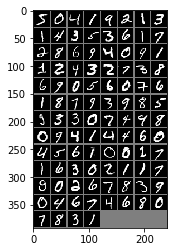

In [5]:
# Image processing
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=(0.5, 0.5, 0.5),
                                     std=(0.5, 0.5, 0.5))])
# MNIST dataset
mnist = datasets.MNIST(root='./data/',
                       train=True,
                       transform=transform,
                       download=True)
# Data loader
data_loader = torch.utils.data.DataLoader(dataset=mnist,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          drop_last=True)

print(len(data_loader.dataset))
imgs = 0
for n,(img,labels) in enumerate(data_loader):
    print(n,img.shape,labels.shape)
    imgs = img
    break
    
print(imgs.shape)
imshow(torchvision.utils.make_grid(imgs))

#imshow(torchvision.utils.make_grid(imgs.view(batch_size, -1)))
#print(imgs.view(100, -1).shape)


In [6]:
# Discriminator
D = nn.Sequential(
    nn.Linear(784, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 1),
    nn.Sigmoid())

# Generator
G = nn.Sequential(
    nn.Linear(z_dim, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 784),
    nn.Tanh())

if torch.cuda.is_available():
    D.cuda()
    G.cuda()

In [7]:
# Binary cross entropy loss and optimizer
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=lr)
g_optimizer = torch.optim.Adam(G.parameters(), lr=lr)

In [8]:
# [-1,1] -> [0,1]
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

In [9]:

# model restore if any
try:
    G.load_state_dict(torch.load('./generator.pkl'))
    D.load_state_dict(torch.load('./discriminator.pkl'))
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass


--------model restored--------



In [10]:
# Start training
total_batch = len(data_loader.dataset)//batch_size
for epoch in range(max_epoch):
    for i, (images, _) in enumerate(data_loader):
        # Build mini-batch dataset
        images = Variable(images.view(batch_size, -1)).cuda()
        #print(images.shape)
        # Create the labels which are later used as input for the BCE loss
        real_labels = Variable(torch.ones(batch_size)).cuda()
        fake_labels = Variable(torch.zeros(batch_size)).cuda()

        #============= Train the discriminator =============#
        # Compute BCE_Loss using real images where BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))
        # Second term of the loss is always zero since real_labels == 1
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        #print(d_loss_real)
        real_score = outputs

        # Compute BCELoss using fake images
        # First term of the loss is always zero since fake_labels == 0
        z = Variable(torch.randn(batch_size, z_dim)).cuda()
        fake_images = G(z).detach()
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs

        # Backprop + Optimize
        d_loss = d_loss_real + d_loss_fake
        D.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        #=============== Train the generator ===============#
        # Compute loss with fake images
        z = Variable(torch.randn(batch_size, z_dim)).cuda()
        fake_images = G(z)
        outputs = D(fake_images)

        # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
        # For the reason, see the last paragraph of section 3. https://arxiv.org/pdf/1406.2661.pdf
        g_loss = criterion(outputs, real_labels)

        # Backprop + Optimize
        D.zero_grad()
        G.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        if (i+1) % 300 == 0:
            print('Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, '
                  'g_loss: %.4f, D(x): %.2f, D(G(z)): %.2f'
                  %(epoch, max_epoch, i+1, total_batch, d_loss.data.item(), g_loss.item(),
                    real_score.mean().item(), fake_score.mean().item()))
            
# Save the trained parameters
torch.save(G.state_dict(), './generator.pkl')
torch.save(D.state_dict(), './discriminator.pkl')

c:\users\dglee\appdata\local\conda\conda\envs\pytorch\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch [0/300], Step[300/600], d_loss: 0.3934, g_loss: 3.0293, D(x): 0.87, D(G(z)): 0.10
Epoch [0/300], Step[600/600], d_loss: 0.3200, g_loss: 3.4833, D(x): 0.94, D(G(z)): 0.13
Epoch [1/300], Step[300/600], d_loss: 0.3996, g_loss: 2.6019, D(x): 0.87, D(G(z)): 0.10
Epoch [1/300], Step[600/600], d_loss: 0.2930, g_loss: 3.1833, D(x): 0.94, D(G(z)): 0.12
Epoch [2/300], Step[300/600], d_loss: 0.3113, g_loss: 2.6256, D(x): 0.88, D(G(z)): 0.09
Epoch [2/300], Step[600/600], d_loss: 0.2502, g_loss: 3.6145, D(x): 0.91, D(G(z)): 0.07
Epoch [3/300], Step[300/600], d_loss: 0.4980, g_loss: 2.9235, D(x): 0.84, D(G(z)): 0.08
Epoch [3/300], Step[600/600], d_loss: 0.3434, g_loss: 4.0014, D(x): 0.92, D(G(z)): 0.14
Epoch [4/300], Step[300/600], d_loss: 0.3774, g_loss: 3.0920, D(x): 0.85, D(G(z)): 0.05
Epoch [4/300], Step[600/600], d_loss: 0.2990, g_loss: 3.7689, D(x): 0.90, D(G(z)): 0.06
Epoch [5/300], Step[300/600], d_loss: 0.3471, g_loss: 3.1653, D(x): 0.88, D(G(z)): 0.10
Epoch [5/300], Step[600/600], d_

Epoch [92/300], Step[300/600], d_loss: 0.3193, g_loss: 3.6093, D(x): 0.89, D(G(z)): 0.07
Epoch [92/300], Step[600/600], d_loss: 0.1735, g_loss: 4.1384, D(x): 0.94, D(G(z)): 0.05
Epoch [93/300], Step[300/600], d_loss: 0.3502, g_loss: 3.0845, D(x): 0.87, D(G(z)): 0.08
Epoch [93/300], Step[600/600], d_loss: 0.1366, g_loss: 4.3592, D(x): 0.96, D(G(z)): 0.06
Epoch [94/300], Step[300/600], d_loss: 0.3799, g_loss: 3.2590, D(x): 0.88, D(G(z)): 0.08
Epoch [94/300], Step[600/600], d_loss: 0.1884, g_loss: 3.5123, D(x): 0.95, D(G(z)): 0.07
Epoch [95/300], Step[300/600], d_loss: 0.4044, g_loss: 3.8941, D(x): 0.86, D(G(z)): 0.06
Epoch [95/300], Step[600/600], d_loss: 0.2062, g_loss: 3.4091, D(x): 0.95, D(G(z)): 0.09
Epoch [96/300], Step[300/600], d_loss: 0.3918, g_loss: 4.0000, D(x): 0.84, D(G(z)): 0.03
Epoch [96/300], Step[600/600], d_loss: 0.1704, g_loss: 3.5662, D(x): 0.96, D(G(z)): 0.09
Epoch [97/300], Step[300/600], d_loss: 0.3557, g_loss: 3.0713, D(x): 0.87, D(G(z)): 0.07
Epoch [97/300], Step[

Epoch [183/300], Step[300/600], d_loss: 0.3061, g_loss: 3.8536, D(x): 0.90, D(G(z)): 0.07
Epoch [183/300], Step[600/600], d_loss: 0.2383, g_loss: 3.8394, D(x): 0.92, D(G(z)): 0.05
Epoch [184/300], Step[300/600], d_loss: 0.2469, g_loss: 3.3475, D(x): 0.91, D(G(z)): 0.07
Epoch [184/300], Step[600/600], d_loss: 0.2193, g_loss: 3.6713, D(x): 0.94, D(G(z)): 0.09
Epoch [185/300], Step[300/600], d_loss: 0.3140, g_loss: 3.6384, D(x): 0.88, D(G(z)): 0.05
Epoch [185/300], Step[600/600], d_loss: 0.1992, g_loss: 3.5718, D(x): 0.95, D(G(z)): 0.09
Epoch [186/300], Step[300/600], d_loss: 0.2880, g_loss: 3.5388, D(x): 0.90, D(G(z)): 0.07
Epoch [186/300], Step[600/600], d_loss: 0.1920, g_loss: 3.8709, D(x): 0.94, D(G(z)): 0.05
Epoch [187/300], Step[300/600], d_loss: 0.2993, g_loss: 4.0486, D(x): 0.87, D(G(z)): 0.04
Epoch [187/300], Step[600/600], d_loss: 0.1613, g_loss: 3.7803, D(x): 0.95, D(G(z)): 0.06
Epoch [188/300], Step[300/600], d_loss: 0.2951, g_loss: 4.0390, D(x): 0.89, D(G(z)): 0.06
Epoch [188

Epoch [274/300], Step[300/600], d_loss: 0.3046, g_loss: 3.8356, D(x): 0.89, D(G(z)): 0.04
Epoch [274/300], Step[600/600], d_loss: 0.2107, g_loss: 3.7932, D(x): 0.93, D(G(z)): 0.07
Epoch [275/300], Step[300/600], d_loss: 0.2292, g_loss: 4.0214, D(x): 0.90, D(G(z)): 0.05
Epoch [275/300], Step[600/600], d_loss: 0.2101, g_loss: 4.9337, D(x): 0.94, D(G(z)): 0.04
Epoch [276/300], Step[300/600], d_loss: 0.2951, g_loss: 4.0128, D(x): 0.90, D(G(z)): 0.06
Epoch [276/300], Step[600/600], d_loss: 0.2756, g_loss: 3.8580, D(x): 0.94, D(G(z)): 0.13
Epoch [277/300], Step[300/600], d_loss: 0.3821, g_loss: 4.0964, D(x): 0.88, D(G(z)): 0.07
Epoch [277/300], Step[600/600], d_loss: 0.2010, g_loss: 4.0926, D(x): 0.95, D(G(z)): 0.06
Epoch [278/300], Step[300/600], d_loss: 0.3763, g_loss: 3.2279, D(x): 0.89, D(G(z)): 0.12
Epoch [278/300], Step[600/600], d_loss: 0.2307, g_loss: 3.6550, D(x): 0.94, D(G(z)): 0.09
Epoch [279/300], Step[300/600], d_loss: 0.3246, g_loss: 4.0437, D(x): 0.89, D(G(z)): 0.05
Epoch [279

torch.Size([100, 64])
tensor([-0.4800, -0.4800, -0.4800, -0.4800, -0.4800, -0.4800, -0.4800, -0.4800,
        -0.4800, -0.4800, -0.4800, -0.4800, -0.4800, -0.4800, -0.4800, -0.4800,
        -0.4800, -0.4800, -0.4800, -0.4800, -0.4800, -0.4800, -0.4800, -0.4800,
        -0.4800, -0.4800, -0.4800, -0.4800, -0.4800, -0.4800, -0.4800, -0.4800,
        -0.4800, -0.4800, -0.4800, -0.4800, -0.4800, -0.4800, -0.4800, -0.4800,
        -0.4800, -0.4800, -0.4800, -0.4800, -0.4800, -0.4800, -0.4800, -0.4800,
        -0.4800, -0.4800, -0.4800, -0.4800, -0.4800, -0.4800, -0.4800, -0.4800,
        -0.4800, -0.4800, -0.4800, -0.4800, -0.4800, -0.4800, -0.4800, -0.4800],
       device='cuda:0')


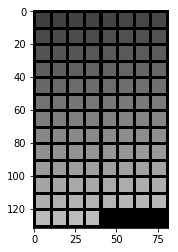

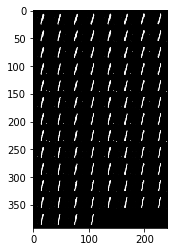

In [38]:
batch_size = 100
z = Variable(torch.randn(batch_size, z_dim)).cuda()
j = -0.5
print(z.shape)  
for i in range(batch_size):
    z[i].fill_(j)
    j+=0.01
print(z[2])    
fake_images = G(z)
noize_z = make_grid(denorm(z.data.view(batch_size,1,8,8))).cpu().permute(1,2,0).numpy()
fake_images = make_grid(denorm(fake_images.data.view(batch_size,1,28,28))).cpu().permute(1,2,0).numpy()

plt.imshow(noize_z,cmap='gray')
plt.show()

plt.imshow(fake_images,cmap='gray')
plt.show()